#Task 2

In [ ]:
wandb.init(project='DL_assignment4', name='task1')

#Define Classifier

In [ ]:
import torch.nn as nn
import torch.nn.init as init
import torchvision

class ComplexCNNClassifier(nn.Module):
  def __init__(self, number_of_classes=7, dropout_prob=0.1):
    super(ComplexCNNClassifier, self).__init__()
    self.resnet = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
    self.resnet.fc = nn.Linear(self.resnet.fc.in_features, number_of_classes)

  def forward(self, x):
    x = self.resnet(x)
    return x


In [ ]:
classifier = ComplexCNNClassifier().to(DEVICE)
classifier

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


ComplexCNNClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:
columns = ["classes", "images", "truth", "predictions"]
test_dt = wandb.Table(columns = columns)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
def evaluate_model(data_loader):
    # Set the classifier to evaluation mode
    classifier.eval()

    # Initialize variables for tracking total and correct predictions
    total_samples, correct_predictions = 0, 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over batches in the data loader
        for batch_data in data_loader:
            # Extract inputs and labels from the batch data
            inputs, _, _, labels = batch_data

            # Move inputs and labels to the device (e.g., GPU)
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Forward pass through the classifier
            outputs = classifier(inputs)

            # Get the predicted class labels
            _, predicted = torch.max(outputs.data, 1)

            # Update total number of samples and correct predictions
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate the accuracy of the classifier
    accuracy = (correct_predictions * 100) / total_samples

    return accuracy


In [ ]:
# Train the classifier for a certain number of epochs
max_epochs = 10
loss_epoch_arr = []  # List to store loss values per epoch
training_accuracy_per_epoch = []  # List to store training accuracy per epoch
testing_accuracy_per_epoch = []  # List to store testing accuracy per epoch

# Iterate over epochs
for epoch in range(max_epochs):
    # Iterate over batches in the training data loader
    for batch_data in tqdm(data_loader.train_dataloader()):
        # Extract inputs and labels from the batch data
        batch_inputs, _, _, batch_labels = batch_data

        # Move inputs and labels to the device (e.g., GPU)
        batch_inputs, batch_labels = batch_inputs.to(DEVICE), batch_labels.to(DEVICE)

        # Reset optimizer gradients
        optimizer.zero_grad()

        # Forward pass through the classifier
        outputs = classifier(batch_inputs)

        # Calculate the loss
        loss = loss_function(outputs, batch_labels)

        # Backpropagation
        loss.backward()

        # Update optimizer parameters
        optimizer.step()

    # Track loss per epoch
    loss_epoch_arr.append(loss.item())

    # Evaluate training and testing accuracy per epoch
    training_accuracy = evaluate_model(data_loader.train_dataloader())
    testing_accuracy = evaluate_model(data_loader.test_dataloader())

    # Append accuracy values to respective lists
    training_accuracy_per_epoch.append(training_accuracy / 100)
    testing_accuracy_per_epoch.append(testing_accuracy / 100)

    # Log loss and accuracy values to Weights & Biases
    wandb.log({"training_loss_classifier": loss, "Test_Accuracy": testing_accuracy, "Training_Accuracy": training_accuracy}, step=epoch)

    # Print epoch-wise information
    print(f"Epoch: {epoch+1}/{max_epochs}, Loss: {loss}, Test Accuracy: {testing_accuracy}, Training Accuracy: {training_accuracy}")


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:03<00:00,  4.45it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 1/10, Loss: 1.0059205293655396, Test_Accuracy: 73.4, Trainig_Accuracy: 88.40820854132002


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:03<00:00,  4.43it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 2/10, Loss: 0.5400635004043579, Test_Accuracy: 72.1, Trainig_Accuracy: 85.71270105379922


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:04<00:00,  4.35it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 3/10, Loss: 0.49316641688346863, Test_Accuracy: 75.3, Trainig_Accuracy: 88.67443150305047


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:03<00:00,  4.41it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 4/10, Loss: 0.3172021806240082, Test_Accuracy: 79.1, Trainig_Accuracy: 93.36661120354964


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:03<00:00,  4.42it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 5/10, Loss: 0.5112188458442688, Test_Accuracy: 76.3, Trainig_Accuracy: 92.90072102052136


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:04<00:00,  4.37it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 6/10, Loss: 0.14782166481018066, Test_Accuracy: 77.7, Trainig_Accuracy: 97.19356627842485


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:03<00:00,  4.46it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 7/10, Loss: 0.056131284683942795, Test_Accuracy: 78.3, Trainig_Accuracy: 98.64669994453688


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:04<00:00,  4.34it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 8/10, Loss: 0.42133042216300964, Test_Accuracy: 78.3, Trainig_Accuracy: 96.10648918469218


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:03<00:00,  4.43it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 9/10, Loss: 0.37695640325546265, Test_Accuracy: 75.3, Trainig_Accuracy: 96.25069328896284


  0%|          | 0/282 [00:00<?, ?it/s]/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
100%|██████████| 282/282 [01:03<00:00,  4.43it/s]
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

Epoch: 10/10, Loss: 0.07271932065486908, Test_Accuracy: 78.1, Trainig_Accuracy: 98.5246810870771


In [ ]:
# Iterate through the dataloader dictionary
for category, data_loader in dataloader_dict.items():
    # Iterate through batches in the data loader
    for batch_data in data_loader:
        # Extract real images, labels, sketches, and classes from the batch data
        real_images, labels, sketches, classes = batch_data

        # Generate fake images using the generator
        fake_images = generator(sketches, labels)

        # Evaluate the generated fake images and calculate accuracy and probabilities
        accuracy, probabilities = evaluate_model(fake_images, classes)

        # Convert real images to WandB image format
        real_images_wandb = [wandb.Image(image) for image in real_images]

        # Convert class labels and prediction probabilities to lists
        class_labels = classes.tolist()
        prediction_probabilities = probabilities.tolist()

        # Zip the data for each image in the batch
        rows = zip(class_labels, real_images_wandb, class_labels, prediction_probabilities)

        # Add data to the test data table for each image in the batch
        for row in rows:
            test_data_table.add_data(*row)


In [ ]:
wandb.log({TEST_TABLE_NAME : test_dt})

#Test

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/generator.pth')

In [ ]:
generator.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
generator.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 96, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): 

In [ ]:
with torch.no_grad():
    outputs = generator(sketches, labels)

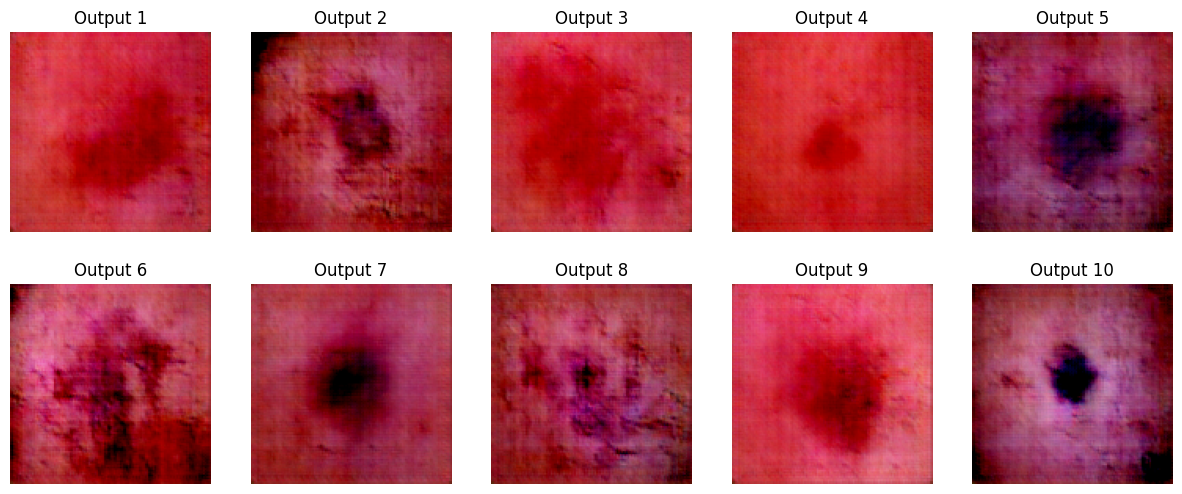

In [ ]:
# Display the output for 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    output_image = outputs[i].permute(1, 2, 0).cpu().numpy()  # Convert from tensor to numpy array and rearrange dimensions
    ax = axes[i // 5, i % 5]
    ax.imshow(output_image)
    ax.axis('off')
    ax.set_title(f'Output {i+1}')
plt.show()

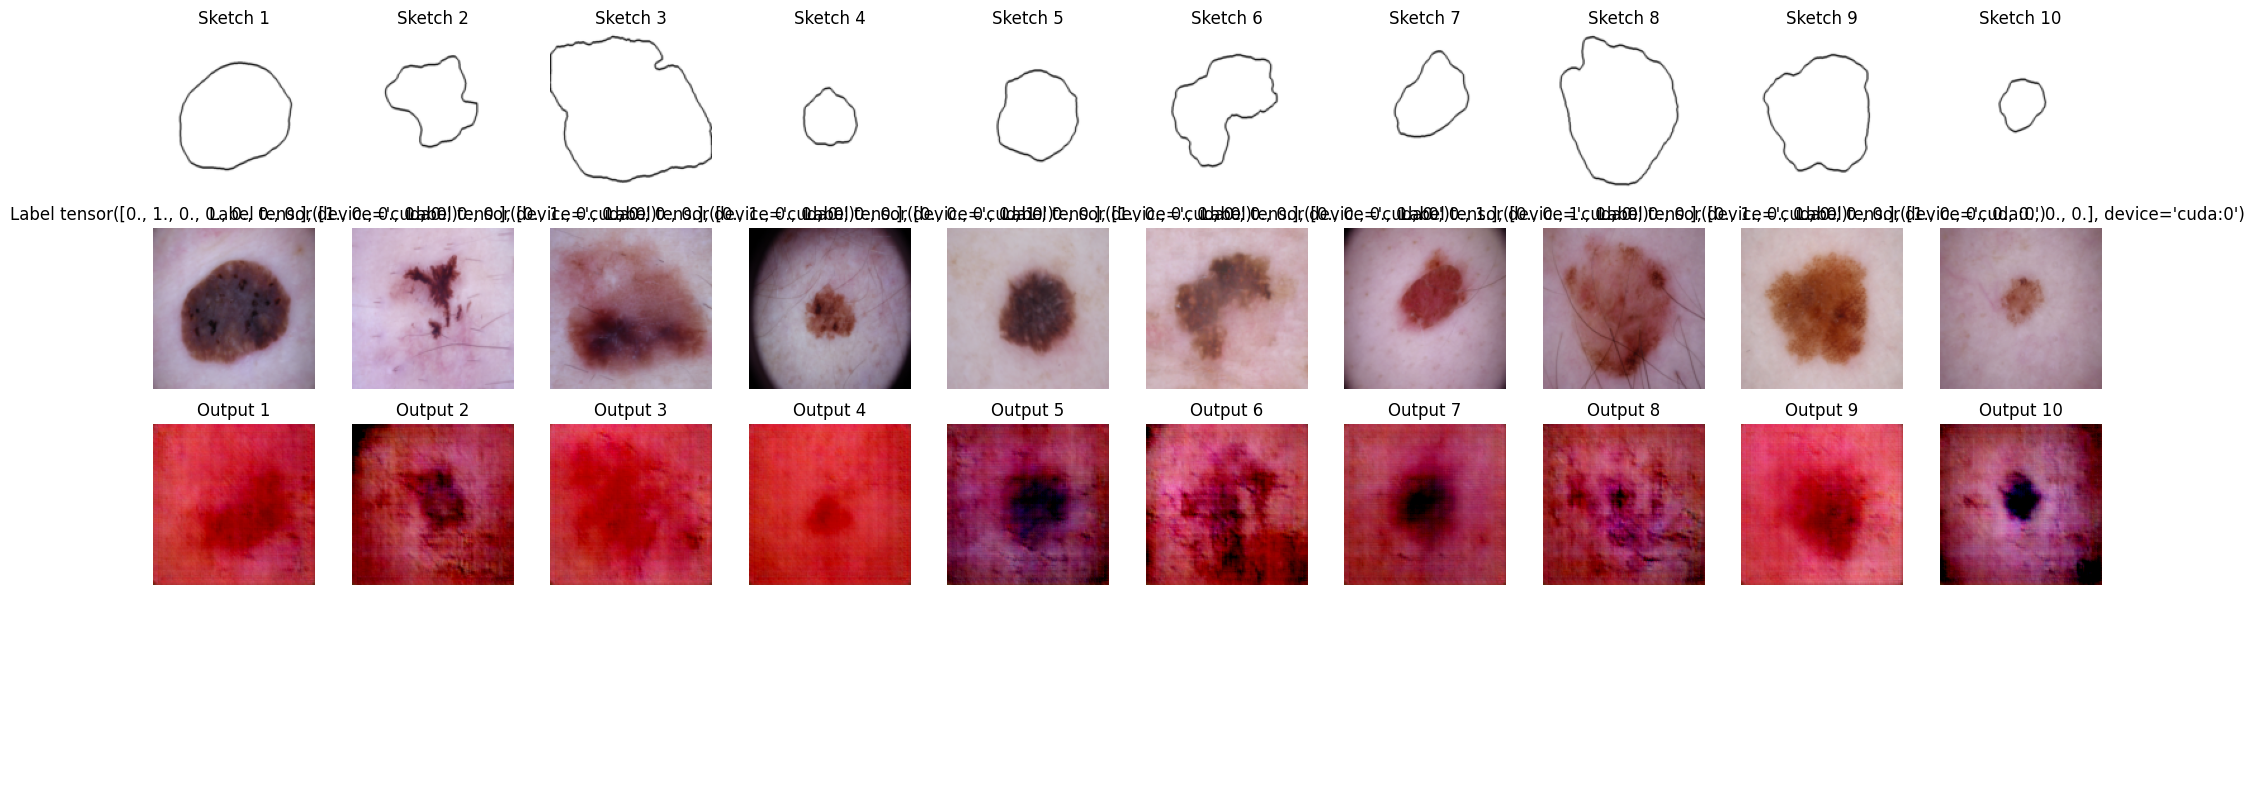

In [ ]:
# Display the output for 10 images along with their sketches and labels
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
for i in range(10):
    # Plot original sketch with label
    axes[0, i].imshow(sketches[i].permute(1, 2, 0).cpu().numpy())
    axes[0, i].set_title(f'Sketch {i+1}')
    axes[0, i].axis('off')

    # Plot original image with label
    axes[1, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
    axes[1, i].set_title(f'Label {labels[i]}')  # Update to display entire tensor
    axes[1, i].axis('off')

    # Plot generated output
    output_image = outputs[i].permute(1, 2, 0).cpu().numpy()
    axes[2, i].imshow(output_image)
    axes[2, i].set_title(f'Output {i+1}')
    axes[2, i].axis('off')

# Hide empty subplots
for ax in axes[3, :]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from torchvision.models import inception_v3
from scipy.stats import entropy
def inception_score(images, batch_size=32, splits=10):
    model = inception_v3(weights='Inception_V3_Weights.DEFAULT', transform_input=False).eval()
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
    ])

    preds = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch = torch.stack([preprocess(img) for img in batch], dim=0)
            pred = torch.nn.functional.softmax(model(batch), dim=1).cpu().numpy()
            preds.append(pred)
    preds = np.concatenate(preds, axis=0)

    p_y = np.mean(preds, axis=0)

    scores = []
    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits), :]
        q_y_x = np.mean(part, axis=0)
        kl_d = entropy(p_y, q_y_x)
        scores.append(kl_d)

    scores = np.array(scores)
    is_score = np.exp(np.mean(scores))

    return is_score

In [ ]:
is_score = inception_score(outputs)
print("Inception Score:", is_score)

In [ ]:
from torchvision import models
from scipy.linalg import sqrtm

class InceptionV3(nn.Module):
    def __init__(self):
        super(InceptionV3, self).__init__()
        self.model = models.inception_v3(weights='Inception_V3_Weights.DEFAULT', aux_logits=True)
        self.model.eval()

    def forward(self, x):
        return self.model(x)

def calculate_fid(real_images, generated_images, batch_size=50, device='cuda'):
    inception_model = InceptionV3().to(device)
    def preprocess(images):
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        images = (images - 0.5) * 2
        return images

    real_activations = []
    with torch.no_grad():
        for i in range(0, len(real_images), batch_size):
            batch = preprocess(real_images[i:i+batch_size].to(device))
            activations = inception_model(batch)
            real_activations.append(activations.cpu().detach().numpy())
    real_activations = np.concatenate(real_activations, axis=0)

    generated_activations = []
    with torch.no_grad():
        for i in range(0, len(generated_images), batch_size):
            batch = preprocess(generated_images[i:i+batch_size].to(device))
            activations = inception_model(batch)
            generated_activations.append(activations.cpu().detach().numpy())
    generated_activations = np.concatenate(generated_activations, axis=0)

    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_gen, sigma_gen = np.mean(generated_activations, axis=0), np.cov(generated_activations, rowvar=False)

    eps = 1e-6
    sigma_real += eps * np.eye(sigma_real.shape[0])
    sigma_gen += eps * np.eye(sigma_gen.shape[0])

    sqrt_sigma_real = sqrtm(sigma_real)
    sqrt_sigma_real_sigma_gen_sqrt = sqrtm(sqrt_sigma_real @ sigma_gen @ sqrt_sigma_real)
    if np.iscomplexobj(sqrt_sigma_real_sigma_gen_sqrt):
        sqrt_sigma_real_sigma_gen_sqrt = sqrt_sigma_real_sigma_gen_sqrt.real
    fid = np.linalg.norm(mu_real - mu_gen) + np.trace(sigma_real + sigma_gen - 2 * sqrt_sigma_real_sigma_gen_sqrt)

    return fid

In [ ]:
fid_score = calculate_fid(images,outputs)
print("FID Score:", fid_score)

FID Score: 619.437753261718


In [ ]:
classifier_dist = torch.load('/content/drive/MyDrive/cnn_classifier.pth')

In [ ]:
classifier.load_state_dict(classifier_dist)
classifier.eval()

ComplexCNNClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:
from tabulate import tabulate
columns = ["images", "truth_label", "predictions"]
test_data = []

def classify_images(images):
    with torch.no_grad():
        images = images.to(DEVICE)
        outputs = classifier(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
    return probabilities, predictions

with torch.no_grad():
    probabilities, predictions = classify_images(outputs)

# Convert labels tensor to a list
labels_list = labels.tolist()

for i in range(len(sketches)):
    # Convert generated image tensor to WandB image format
    generated_image = wandb.Image(outputs[i])

    # Get the class label of the sketch
    sketch_class_label = labels_list[i]

    # Get the predicted class label and probability
    predicted_class_label = predictions[i].item()
    predicted_probability = probabilities[i, predicted_class_label].item()

    test_data.append([generated_image, sketch_class_label, predicted_class_label])

print(tabulate(test_data, headers=columns, showindex="never"))


images                                                       truth_label                            predictions
-----------------------------------------------------------  -----------------------------------  -------------
<wandb.sdk.data_types.image.Image object at 0x7be1502232e0>  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]              1
<wandb.sdk.data_types.image.Image object at 0x7be150223d60>  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]              1
<wandb.sdk.data_types.image.Image object at 0x7be150246c80>  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]              1
<wandb.sdk.data_types.image.Image object at 0x7be1502472b0>  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]              1
<wandb.sdk.data_types.image.Image object at 0x7be150245a50>  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]              4
<wandb.sdk.data_types.image.Image object at 0x7be150246fe0>  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]              4
<wandb.sdk.data_types.image.Image object at 0x7be150246e30>  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]        

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define dataset
class CustomDataset(Dataset):
    def _init_(self, img_paths, transform=None, num_copies=1):
        self.img_paths = img_paths
        self.transform = transform

    def _len_(self):
        return len(self.img_paths)

    def _getitem_(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        one_hot_vector = torch.eye(6)


        if self.transform:
            image = self.transform(image)

        return image

image_paths = ["/content/drive/MyDrive/Test1/Test/Paired_test_sketch/Sketch_1.png", "/content/drive/MyDrive/Test1/Test/Paired_test_sketch/Sketch_10.png"]

dataset = CustomDataset(image_paths, transform=transform, num_copies=16)

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for images in data_loader:
    print(images.shape)

TypeError: CustomDataset() takes no arguments

In [ ]:
num_rows = 2
num_cols = 7

one_hot_tensor = torch.zeros(num_rows, num_cols)

# Set the diagonal elements to 1 to create the one-hot encoding
one_hot_tensor[torch.arange(num_rows), torch.randint(num_cols, size=(num_rows,))] = 1
one_hot_tensor.shape

In [ ]:
def plot_images_from_tensor(image_tensor, name, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
#     wandb.log({name: image_grid.permute(1, 2, 0).squeeze()})
#     wandb.log({name: [wandb.Image(image_grid.permute(1, 2, 0).squeeze().cpu().numpy(), caption=name)]})
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
      plt.show()


In [ ]:
for test in tqdm(data_loader):
#     one_hot_vector = torch.eye(7)
#     reshaped_tensor = one_hot_vector.view(2, -1)
    fake = generator(test, one_hot_tensor)

#     accuracy, probabilities = evaluation(fake, one_hot_vector)
#     plot_images_from_tensor(fake, name="fake_images")
#     plot_images_from_tensor(test, name="test_images")
#     accuracy_lst.append(accuracy)
    plot_images_from_tensor(fake, " ")

In [ ]:
plot_images_from_tensor